In [2]:
import numpy as np
import pandas as pd
import segyio
import os
import csv
import multiprocessing
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool
import time 

from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from scipy.signal import fftconvolve
from scipy.signal import gaussian
from scipy.signal import hilbert
from scipy.ndimage import rotate
from scipy.ndimage.filters import convolve1d
from scipy.ndimage import median_filter
from scipy.ndimage import generic_filter1d
from scipy.signal import butter
from scipy.signal import filtfilt
from scipy.interpolate import BSpline



import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.set_option('display.max_rows', 200)

In [2]:
# update working directory and file names below

infile = '2D-line.sgy'
velfile = '2D-line-velocity.txt'
#compfile = 'parex-line10-stk_final.sgy'
#outfile = 'parex-line10-stk-pyfinal.sgy'
#testfile = 'test_output.sgy'


# Step 1 of workflow

In [3]:
# read in gathers using sequential programing
start=time.time()
with segyio.open(infile, ignore_geometry=True) as src:
    n_traces = src.tracecount
    sample_rate = segyio.tools.dt(src) / 1000
    n_samples = src.samples.size
    twt = src.samples
    cdp = np.asarray([int(src.header[i][21]) for i in range(src.tracecount)])
    offset = np.asarray([src.header[i][37] for i in range(src.tracecount)])
    fnl_stat = np.asarray([src.header[i][237] for i in range(src.tracecount)])
    intpdist = np.asarray([src.header[i][233] for i in range(src.tracecount)])
    datagath = src.trace.raw[:]
end=time.time()
time_sequen_gath=round(end-start,2)
time_sequen_gath

59.27

In [4]:
dath_row=datagath.shape[0]
dath_col=datagath.shape[1]

### Used processing pools 

In [5]:
%%file func_segopen.py
def read_traces(infile):
    import segyio
    import numpy as np
    with segyio.open(infile, ignore_geometry=True) as src:
        n_traces = src.tracecount
        sample_rate = segyio.tools.dt(src) / 1000
        n_samples = src.samples.size
        twt = src.samples
        cdp = np.asarray([int(src.header[i][21]) for i in range(src.tracecount)])
        offset = np.asarray([src.header[i][37] for i in range(src.tracecount)])
        fnl_stat = np.asarray([src.header[i][237] for i in range(src.tracecount)])
        intpdist = np.asarray([src.header[i][233] for i in range(src.tracecount)])
        return src.trace.raw[:]


Overwriting func_segopen.py


In [6]:
from func_segopen import read_traces
# read in gathers in parallel using processes
#the path has to be a python list in the map function, not sure why 
infile = ['2D-line.sgy']

start=time.time()
P_pool =Pool(processes=multiprocessing.cpu_count())
datagath=P_pool.map(read_traces,infile)
#need to add this portion to the code due to the map function in pools
datagath=np.ravel(datagath)
datagath= datagath.reshape(dath_row,dath_col)
end=time.time()


time_parallelproce_gath=round(end-start,2)
time_parallelproce_gath

40.38

### Used Threading pools 

In [7]:
from func_segopen import read_traces
# read in gathers in parallel using processes
#the path has to be a python list in the map function, not sure why 
infile = ['2D-line.sgy']
def read_traces(infile):
    import segyio
    import numpy as np
    with segyio.open(infile, ignore_geometry=True) as src:
        n_traces = src.tracecount
        sample_rate = segyio.tools.dt(src) / 1000
        n_samples = src.samples.size
        twt = src.samples
        cdp = np.asarray([int(src.header[i][21]) for i in range(src.tracecount)])
        offset = np.asarray([src.header[i][37] for i in range(src.tracecount)])
        fnl_stat = np.asarray([src.header[i][237] for i in range(src.tracecount)])
        intpdist = np.asarray([src.header[i][233] for i in range(src.tracecount)])
        return src.trace.raw[:]
    
#start time here
start=time.time()
T_pool = ThreadPool(processes=multiprocessing.cpu_count())
datagath_Thr = T_pool.map(read_traces,infile)
#need to add this portion to the code due to the map function in pools
datagath=np.ravel(datagath)
datagath= datagath.reshape(dath_row,dath_col)
end=time.time()

time_parallelthread_gath=round(end-start,2)
time_parallelthread_gath

60.61

### Comparing times 

In [8]:
#putting them in an array
t_read_traces=np.asarray([time_sequen_gath, time_parallelproce_gath, time_parallelthread_gath])
#obtaining the minimum of the array, which will return the optimized time using different programing methods. Position 1 is always pool of processes, and position 2 is always a pool of threads.
if np.argmin(t_read_traces)==1:
    print('The optimized time is obtained by using a pool Processes')
else:
    print('The optimized time is obtained by using a pool of Threads')

The optimized time is obtained by using a pool Processes


In [9]:
t_read_traces

array([59.27, 40.38, 60.61])

### A pool of Threads seem to perform better in this stage of the workflow. This makes sense, as most steps in this workflow are I/O bound; the only CPU bound (computation) here is the sample rate line.

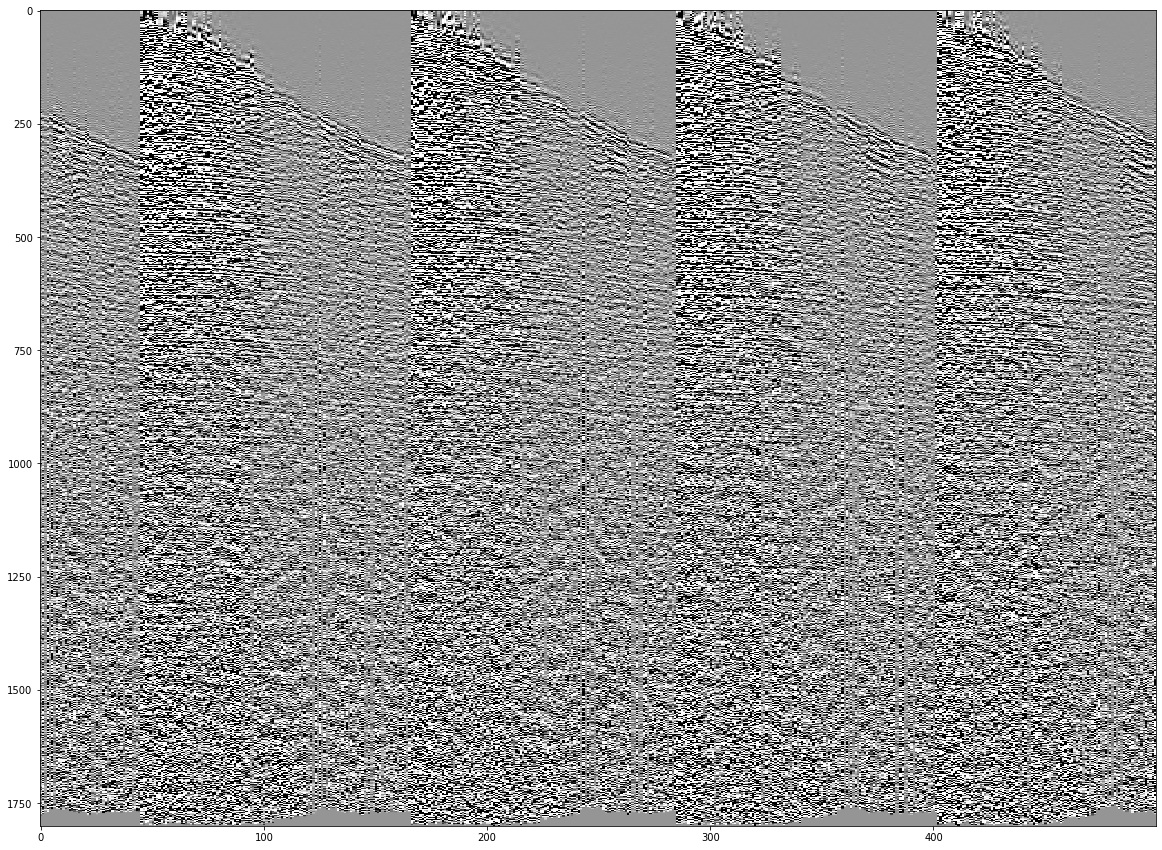

In [10]:
# qc input

plt.figure(figsize=(20,15))
plt.imshow(datagath[100000:100500].T,cmap='Greys', vmin=-0.1, vmax=0.1, aspect='auto',)

# Step 2 , only at the moveout cell

In [11]:
# import velocity for stretch mute

with open(velfile, newline='') as vel:
    velocity = csv.reader(vel, delimiter=' ', skipinitialspace=True)
    for i in range(4):
        next(velocity)
    row_count = sum(1 for row in velocity)
    
velcdp = np.zeros(shape=row_count)
veltime = np.zeros(shape=row_count)
velrms = np.zeros(shape=row_count)

with open(velfile, newline='') as vel:
    velocity = csv.reader(vel, delimiter=' ', skipinitialspace=True)
    for i in range(4):
        next(velocity)    
    for i, row in enumerate(velocity):
        velcdp[i] = row[0]
        veltime[i] = row[1]
        velrms[i] = row[2]
    

In [12]:
# interpolate velocity

velcdps = np.asarray(sorted(set(velcdp)))
cdps = np.asarray(sorted(set(cdp)))

velrms2 = np.zeros(shape=(len(velcdps), len(twt)))
velrms3 = np.zeros(shape=(len(cdps), len(twt)))
display(velrms2.shape, velrms3.shape)

for j, i in enumerate(velcdps):
    ind = np.where(velcdp==i)[0]
    velrms2[j] = interp1d(veltime[ind], velrms[ind], fill_value=(0,0), bounds_error=False)(twt)
    temp = np.min(np.nonzero(velrms2[j]))
    velrms2[j,:temp] = velrms2[j,temp]
    temp = np.max(np.nonzero(velrms2[j]))
    velrms2[j,temp:] = velrms2[j,temp]
    
for i in range(len(twt)):
    velrms3[:,i] = interp1d(velcdps, velrms2[:,i], fill_value=(0,0), bounds_error=False)(cdps)
    temp = np.min(np.nonzero(velrms3[:,i]))
    velrms3[:temp,i] = velrms3[temp,i]
    temp = np.max(np.nonzero(velrms3[:,i]))
    velrms3[temp:,i] = velrms3[temp,i]    



(44, 1801)

(2239, 1801)

### Regular sequence programing....although you are using lots of numpy functions ,which already takes away the Global interpreter lock.I'm not sure if multiprocesses will do much of a difference, however I would expect that processes are better than threads here, as this computations are CPU bound.

In [13]:
# apply moveout using sequence programming
display(datagath.shape)

start=time.time()
datanmo = np.zeros(datagath.shape)
for x in range(n_traces):
    velloc = np.argwhere(cdps==cdp[x]).item()
    nmo = np.sqrt(twt**2 + (offset[x]**2/velrms3[velloc]**2)*1000000)
    datanmo[x] = CubicSpline(twt, datagath[x])(nmo)
end=time.time()
moveout_sequ_time=round(end-start,2)
moveout_sequ_time

(195702, 1801)

93.7

In [14]:
velloc=[]
for x in range(n_traces):
    #velloc = np.argwhere(cdps==cdp[x]).items()
    velloc.append(np.argwhere(cdps==cdp[x]).item())
print(len(velloc))

195702


In [15]:
xx=[]
for element in cdps:
    if element in cdp:
        x_1=element
len(xx)        

0

In [16]:
count_v=0
for element in velloc:
    if element== 2237:
        count_v=count_v+1
print(count_v)

1


In [17]:
count_e=0
for element in xx:
    if element ==2237:
        count_e+=1
print(count_e)            

0


In [18]:
print(xx)

[]


In [19]:
print(velloc)

[0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 

### Using processes

In [20]:
# %%file func_moveout2.py

# def datanmo_1(nmo,twt,datagath,n_traces):
#     from scipy.interpolate import CubicSpline
#     for x in range(n_traces):
#         datanmo[x] = CubicSpline(twt, datagath[x])(nmo)
#     return datanmo

In [21]:
# %%file func_moveout2.py

# def velloc_nmo(cdps,cdp,n_traces,twt,velrms3,offset,q1):
#     import numpy as np
#     for x in range(n_traces):
#         velloc = np.argwhere(cdps==cdp[x]).item()
#         nmo = np.sqrt(twt**2 + (offset[x]**2/velrms3[velloc]**2)*1000000)
#     q1.put(nmo)
#     #return nmo
# def datanmo_1(nmo,twt,datagath,n_traces):
#     from scipy.interpolate import CubicSpline
#     for x in range(n_traces):
#         datanmo[x] = CubicSpline(twt, datagath[x])(nmo)
#     return datanmo

In [22]:
# %%file func_moveout3.py

# def velloc_nmo_1(cdps,cdp,n_traces,twt,velrms3,offset,datagath):
#     import numpy as np
#     from scipy.interpolate import CubicSpline
#     datanmo = np.zeros(datagath.shape)
#     for x in range(n_traces):
#         velloc = np.argwhere(cdps==cdp[x]).item()
#         nmo = np.sqrt(twt**2 + (offset[x]**2/velrms3[velloc]**2)*1000000)
#         datanmo[x] = CubicSpline(twt, datagath[x])(nmo)
#     return datanmo


In [23]:

# display(datagath.shape)
# from multiprocessing import Process, Queue
# from func_moveout2 import velloc_nmo,datanmo_1
# start=time.time()
# q1=Queue()
# p1 = Process(target=velloc_nmo, args=(cdps,cdp,n_traces,twt,velrms3,offset,q1))
# p1.start()
# print(q1.get())
# nmo_1=q1.get()
# p2 = Process(target=datanmo_1, args=(nmo_1,twt,datagath,n_traces,))
# p2.start()
# p1.join()
# p2.join()
# end=time.time()
# moveout_process_time=round(end-start,2)
# moveout_process_time

### Using processes pool


In [24]:
# %%file func_moveout1.py
# def nmo(twt,datagath,cdps,cdp,verlms3,n_traces,datanmo):
#     import numpy as np
#     from scipy.interpolate import CubicSpline
#     #print(n_traces)
#     #for x in range(n_traces):
#     #print(x)
#     velloc = np.argwhere(cdps==cdp[n_traces]).item()
#     nmo = np.sqrt(twt**2 + (offset[n_traces]**2/velrms3[velloc]**2)*1000000)
#     datanmo = CubicSpline(twt, datagath)(nmo)
#     return datanmo

In [29]:
twt.shape

(1801,)

In [30]:
twt_1=twt.reshape(len(twt),1)
twt_1.shape

(1801, 1)

In [33]:
%%file func_moveout5.py
def nmo_111(twt,datagath,nmo):
    from scipy.interpolate import CubicSpline
    for x in range(n_traces):
    velloc = np.argwhere(cdps==cdp[x]).item()
    nmo = np.sqrt(twt**2 + (offset[x]**2/velrms3[velloc]**2)*1000000)
    print(twt,datagath,nmo)
    #twt_1=twt.reshape(len(twt),1)
    datanmo= CubicSpline(twt_1, datagath)(nmo)
    return datanmo 

Overwriting func_moveout5.py


In [34]:
from func_moveout5 import nmo_111
datanmo = np.zeros(datagath.shape)
start=time.time()
for x in range(n_traces):
    velloc = np.argwhere(cdps==cdp[x]).item()
    nmo = np.sqrt(twt**2 + (offset[x]**2/velrms3[velloc]**2)*1000000)
#still need to create a bigger array for nmo    
P_pool =Pool(processes=multiprocessing.cpu_count())
datanmo=P_pool.starmap(nmo_111,zip(twt,datagath,nmo))
end=time.time()
moveout_process_time=round(end-start,2)
moveout_process_time

MemoryError: Unable to allocate 2.63 GiB for an array with shape (195702, 1801) and data type float64

In [ ]:
from func_moveout1 import nmo
from multiprocessing import Process
start=time.time()
n_traces1=[traces for traces in range(n_traces)]
datanmo = np.zeros(datagath.shape)
twt1=list(twt)
#must be a list for the starmap function to work
datagath1=list(datagath)
P_pool =Pool(processes=multiprocessing.cpu_count())
datanmo=P_pool.starmap(nmo,zip(twt1,datagath1,cdps,cdp,velrms3,n_traces1,datanmo))
#need to add this portion to the code due to the map function in pools
#datagath=np.ravel(datagath)
#datagath= datagath.reshape(dath_row,dath_col)
end=time.time()
moveout_process_time=round(end-start,2)
moveout_process_time

In [ ]:
# qc gather

plt.figure(figsize=(20,15))
plt.imshow(datanmo[100000:100500].T,cmap='Greys', vmin=-0.1, vmax=0.1, aspect='auto',)

In [ ]:
# stack
start=time.time()
data = np.zeros((len(set(cdp)), datanmo.shape[1]))
j = 0
for i in (set(cdp)):
    gather = datanmo[np.where(cdp==i)[0],:]
    data[j] = gather.sum(axis=0)/((np.count_nonzero(gather, axis=0)**0.5+0.00001))
    j = j + 1
end=time.time()
time_stack_sequen=round(end-start,2)
time_stack_sequen

In [ ]:
gather.shape

In [ ]:
from multiprocessing import Process
start=time.time()
data = np.zeros((len(set(cdp)), datanmo.shape[1]))
j = 0
for i in (set(cdp)):
    gather = datanmo[np.where(cdp==i)[0],:]
    data[j] = gather.sum(axis=0)/((np.count_nonzero(gather, axis=0)**0.5+0.00001))
    j = j + 1
end=time.time()
time_stack_process=round(end-start,2)
time_stack_process

### Trying out processing

In [ ]:
%%file func_stack1.py
def stack(element_cdp,element_data):
    import numpy as np
    from scipy.interpolate import CubicSpline
    #j = 0
    #for i in (set(cdp)):
    gather = datanmo[np.where(cdp==element_cdp)[0],:]
    data[element_data] = gather.sum(axis=0)/((np.count_nonzero(gather, axis=0)**0.5+0.00001))
        #j = j + 1
    return data

In [ ]:
from func_stack1 import stack
# stack
start=time.time()
data = np.zeros((len(set(cdp)), datanmo.shape[1]))
element_cdp=[ element for element in set(cdp)]
element_data= [element for element in range(data.shape[1])]
P_pool =Pool(processes=multiprocessing.cpu_count())
data=P_pool.starmap(stack,zip(element_cdp,element_data))
end=time.time()
time_stack_processing=round(end-start,2)
time_stack_processing

In [ ]:
# qc stk

plt.figure(figsize=(20,15))
plt.imshow(data.T,cmap='Greys', vmin=-0.4, vmax=0.4, aspect='auto',)

In [ ]:
# apply bandpass filter
start=time.time()
b, a = butter(4, (8, 50), btype='bandpass', output='ba', fs=500)
datafilt = np.where(data == 0, 0, filtfilt(b,a, data))
end=time.time()
time_band_seque=round(end-start,2)
time_band_seque

In [ ]:
# qc stk

plt.figure(figsize=(20,15))
plt.imshow(datafilt.T,cmap='Greys', vmin=-0.4, vmax=0.4, aspect='auto',)

In [ ]:
# apply median agc
start=time.time()
datamagc = np.where(datafilt == 0, np.median(np.abs(datafilt)), datafilt)

meadagc = median_filter(np.abs(datamagc[:,::1]), size=(1,500))

datamagc = datamagc/meadagc
    
datamagc = np.where(data == 0, 0, datamagc)
end=time.time()
time_agc=round(end-start,2)
time_agc

In [ ]:
# qc stk

plt.figure(figsize=(20,15))
plt.imshow(datamagc.T,cmap='Greys', vmin=-4, vmax=4, aspect='auto',)